In [2]:
from PIL.ExifTags import TAGS
import pathlib
import csv
import glob
from PIL import Image
import pandas as pd
import os
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
from skimage.color import rgb2gray
import os
import re
import math
import matplotlib.ticker as tck
import argparse
import cv2
import skimage as ski


DATA LOCATION

In [8]:
path = 'C:/Users/srboval1/OneDrive - Aalto University/Instru/Datafiles'
Exp1 = pd.read_csv(path +'/contours_exp1.csv', index_col=None)

In [9]:
columns_to_plot=['cell_line','incubation_time','material','area','aspect_ratio', 'convex hull area', 'convexity_area','convexity_perimeter','compactness' ]
df_plot= Exp1[columns_to_plot]

unique_materials = df_plot['material'].unique()
unique_lines = df_plot['cell_line'].unique()

In [11]:
color=['red','blue','green']


palette = {
    'MCF10A': 'tab:red',
    'MCF10A.DCIS.COM': 'tab:blue',
    'MCF10AT': 'tab:green',
}

lines = [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in color]
labels = ['MCF10A', 'MCF10A.DCIS.COM', 'MCF10AT']


Time-series of mean spheroid areas for each cell line & material

C:\Users\srboval1\AppData\Local\Temp\ipykernel_30188\3523886863.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  specific_df_grp = specific_df.groupby(['cell_line','incubation_time']).mean()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_30188\3523886863.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  specific_df_grp = specific_df.groupby(['cell_line','incubation_time']).mean()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_30188\3523886863.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either spe

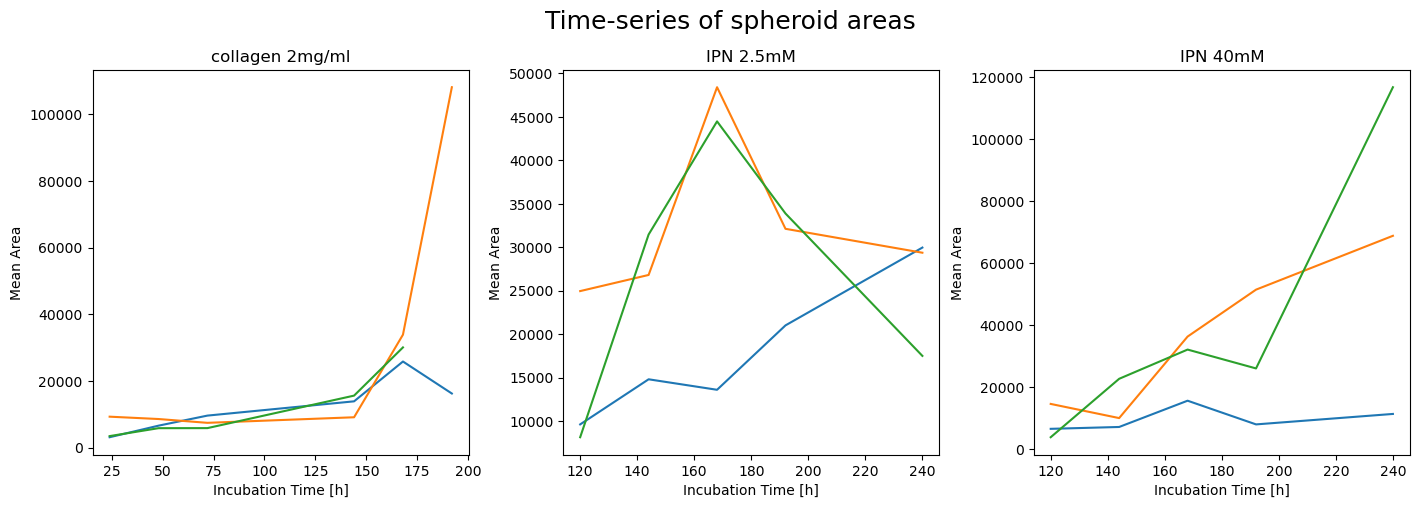

In [13]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(17,5))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
fig.suptitle("Time-series of spheroid areas", fontsize=18, y=1)

for i,unique_material in enumerate(unique_materials):
    specific_df = df_plot[df_plot['material'] == unique_material]
    specific_df_grp = specific_df.groupby(['cell_line','incubation_time']).mean()
    #print(specific_df_grp.head())
    ax=axs[i]
    ax.plot(specific_df_grp.unstack(0)['area']) # area as a function of incubation time, for each cell line
    ax.set_xlabel('Incubation Time [h]')  
    ax.set_ylabel('Mean Area')        
    ax.set_title(unique_material)


In [ ]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
fig.suptitle("Time-series histograms", fontsize=18, y=1)

timestamp = 140     #DEFINE
cuttof_area = 1000  #DEFINE

for i,unique_material in enumerate(unique_materials):
    specific_df = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > cuttof_area) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line) & (specific_df['incubation_time'] < timestamp)]
        ax=axs[j,i]
        sns.kdeplot(specific_specific_df, x='area',ax=ax, hue='incubation_time', log_scale=True, palette=palette)
        ax.set_xlabel('Area')  
        ax.set_title(f'{unique_material} - {unique_line}')
        ax.set_xlim(100,1000000)
        #ax.set_ylim(0,0.6)

Swarmplot time-series

In [ ]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Area", fontsize=18, y=0.95)


for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df_small = specific_df_small[(specific_df_small['cell_line'] == unique_line)]
        specific_specific_df_big = specific_df_big[(specific_df_big['cell_line'] == unique_line)]
        ax=axs[j,i]
        sns.swarmplot(specific_specific_df_small, y='area', ax=ax, x='incubation_time', size=1, marker="x", linewidth=1.5)
        sns.swarmplot(specific_specific_df_big, y='area', ax=ax, x='incubation_time', size=5, marker="o", color=color[j])
        ax.set_xlabel('Incubation time [hours]', fontsize= 12)  
        ax.set_yscale('log')
        ax.set_ylabel('Area', fontsize= 12)  
        ax.set_title(f'{unique_material} - {unique_line}', fontsize= 15)
        ax.set_ylim(1000,10000000)
        #ax.set_ylim(0,0.6)
                
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=8)

plt.savefig(path +'/plots/Time_series_cellsANDspheroids.png',dpi=300)


In [ ]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Spheroid growth", fontsize=20, y=1.1)

for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    
    handles=[]
    labels=[]

    for j,unique_line in enumerate(unique_lines):
        specific_specific_df_small = specific_df_small[(specific_df_small['cell_line'] == unique_line)]
        specific_specific_df_big = specific_df_big[(specific_df_big['cell_line'] == unique_line)]
        ax=axs[i]


        mymodel = np.poly1d(np.polyfit(specific_specific_df_big['incubation_time'], specific_specific_df_big['area'], 1))
        myline = np.linspace(specific_specific_df_big['incubation_time'].min(), specific_specific_df_big['incubation_time'].max(), 100)

        handle, = ax.plot(myline, mymodel(myline), color=color[j], label=unique_line)

        handles.append(handle)
        labels.append(unique_line)

        ax.plot(myline, mymodel(myline), color=color[j])

        ax.set_xlabel('Incubation time [hours]', fontsize= 15)  
        ax.set_yscale('log')
        ax.set_ylabel('Area', fontsize= 15)  
        ax.set_title(f'{unique_material}', fontsize= 18)
        ax.set_ylim(5000,1000000)
        #ax.set_xlim(25,250)
        #ax.set_ylim(0,0.6)              
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=8)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)

plt.savefig(path +'/plots/Spheroid_growth_curve.png',dpi=300)


KDE plot - join distribution time-series

In [ ]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Time-series of density distribution of cells", fontsize=20, y=1.1)


for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    ax=axs[i]

    sns.kdeplot(specific_df_small, x="incubation_time", hue="cell_line", palette=palette, ax=ax,bw_adjust=3, cut=0) #smoothened by adjusting bandwidth
    #legend=(i == len(unique_materials) - 1)
    ax.set_xlabel('Incubation time [hours]', fontsize= 15)  
    ax.set_yscale('log')
    ax.set_ylabel('Density', fontsize= 15)  
    ax.set_title(f'{unique_material}', fontsize= 18)
    #ax.set_ylim(10000,1000000)
    #ax.set_xlim(25,250)
    ax.set_ylim(0.0001,0.1)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.get_legend().set_visible(False)

handles, labels = axs[-1].get_legend_handles_labels()
for line in specific_df_small['cell_line'].unique():
    handles.append(plt.Line2D([0], [0], color=(palette)[line], lw=3))
    labels.append(line)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)


# Make the legend visible for the last subplot




plt.savefig(path +'/plots/Kernel_density_individual_cells.png',dpi=300)


Individual cells count barplots

In [ ]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.15, hspace=0.6)
fig.suptitle("Count of individual cells", fontsize=18, y=1.1)
#fig.legend(loc=7)



for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    ax=axs[i]

    #mymodel = np.poly1d(np.polyfit(specific_specific_df_small['incubation_time'], specific_specific_df_small['area'], 1))
    #myline = np.linspace(specific_specific_df_small['incubation_time'].min(), specific_specific_df_small['incubation_time'].max(), 100)

    sns.countplot(specific_df_small, x="incubation_time", hue="cell_line", palette=palette, ax=ax) #smoothened by adjusting bandwidth
    #sns.histplot(specific_df_small, x="incubation_time", hue="cell_line", palette=palette, ax=ax) #smoothened by adjusting bandwidth

    ax.set_xlabel('Incubation time [hours]', fontsize= 15)  
    ax.set_yscale('log')
    ax.set_ylabel('Count', fontsize= 15)  
    ax.set_title(f'{unique_material}', fontsize= 18)
    #ax.set_ylim(10000,1000000)
    #ax.set_xlim(25,250)
    ax.set_ylim(1,1000)
    ax.get_legend().set_visible(False)


    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)

plt.savefig(path +'/plots/Individual_cells_count_timeseries.png',dpi=300)


In [ ]:
fig, axs = plt.subplots(1, len(unique_materials), figsize=(30,3))
plt.subplots_adjust(wspace=0.25, hspace=0.6)
fig.suptitle("Shape (aspect ratio) of cells", fontsize=18, y=1.1)


color=['red','blue','green']

for i,unique_material in enumerate(unique_materials):
    specific_df_small = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] < 10000) ]
    ax=axs[i]

    #mymodel = np.poly1d(np.polyfit(specific_specific_df_small['incubation_time'], specific_specific_df_small['area'], 1))
    #myline = np.linspace(specific_specific_df_small['incubation_time'].min(), specific_specific_df_small['incubation_time'].max(), 100)

    sns.violinplot(specific_df_small, x="incubation_time",y='aspect_ratio', hue="cell_line", palette=palette, ax=ax,)

    #ax.set_xlabel('Incubation time [hours]', fontsize= 12)  
    #ax.set_yscale('log')
    #ax.set_ylabel('Area', fontsize= 12)  
    ax.set_title(f'{unique_material}', fontsize= 15)
    #ax.set_ylim(10000,1000000)
    #ax.set_xlim(25,250)
    ax.set_ylim(0,10)
    nobs = specific_df_small.groupby(['incubation_time', 'cell_line']).size()
    nobs = [str(x) for x in nobs]  #converts array into list and then to strings
    nobs = ["n: " + i for i in nobs] #adds n in front
    print(nobs)
    #pos = range(len(nobs))
    #for tick, label in zip(pos, ax.get_xticklabels()):
    #    ax.text(pos[tick], 5, nobs[tick],
    #        horizontalalignment='center',
    #        size='small',
    #        color='black')
    ax.get_legend().set_visible(False)
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=15)


plt.savefig(path +'/plots/aspect_ratio_individual_cells.png',dpi=300)


Convexity of spheroids & fit

In [ ]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.1, hspace=0.4)
fig.suptitle("Convexity", fontsize=18, y=0.95)
color=['red','blue','green']


for i,unique_material in enumerate(unique_materials):
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df_big = specific_df_big[(specific_df_big['cell_line'] == unique_line)]
        ax=axs[j,i]

        sns.swarmplot(data=specific_specific_df_big, y='convexity_perimeter', x='incubation_time', size=3, color=color[j], ax=ax)

        ax.set_xlabel('Incubation time [hours]', fontsize= 12)  
        #ax.set_yscale('log')
        ax.set_ylabel('Convexity', fontsize= 12)  
        ax.set_title(f'{unique_material} - {unique_line}', fontsize= 15)
        ax.set_ylim(0.3,1)

plt.savefig(path +'/plots/Convexity_time_series.png',dpi=300)


fig, axs = plt.subplots(1,len(unique_materials),figsize=(30,3.3))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
fig.suptitle("Fit of convexity", fontsize=18, y=1.05)

color=['red','blue','green']

for i,unique_material in enumerate(unique_materials):
    specific_df_big = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 10000) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df_big = specific_df_big[(specific_df_big['cell_line'] == unique_line)]

        #fitting model - determining weights 𝑏₀ and 𝑏₁
        mymodel = np.poly1d(np.polyfit(specific_specific_df_big['incubation_time'], specific_specific_df_big['convexity_perimeter'], 1))
        myline = np.linspace(specific_specific_df_big['incubation_time'].min(), specific_specific_df_big['incubation_time'].max(), 100)

        # Plot the polynomial fit
        # Plot the swarm plot
        ax=axs[i]
        ax.plot(myline, mymodel(myline), color= color[j])

        ax.set_xlabel('Incubation time [hours]', fontsize= 10)  
        #ax.set_yscale('log')
        #ax.set_ylabel('Convexity', fontsize= 12)  
        ax.set_title(f'{unique_material}', fontsize= 12)
        #ax.set_ylim(1000,10000000)
        ax.set_ylim(0.6,1)

plt.savefig(path +'/plots/Convexity_fit.png',dpi=300)


MCF10T: Segmented images & contour area

In [ ]:
csv_path = 'C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis'
df = pd.read_csv(path +'/out.csv', index_col=None)

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10AT\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10AT\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('MCF10AT 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('MCF10AT 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


10A

In [ ]:

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('MCF10A 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('MCF10A 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


DCIS.COM

In [ ]:
csv_path = 'C:/Users/srboval1/Time_Series_Instru/TimeSeriesAnalysis'
df = pd.read_csv(path +'/out.csv', index_col=None)

image_path_1 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A.DCIS.COM\3mM\120h\10x_1_seg.tiff"
image_1 = Image.open(image_path_1)

image_path_2 = r"C:\Users\srboval1\Time_Series_Instru\TimeSeriesAnalysis\230907_IPN15_2mgml_2500cellsml_sqaurewells\MCF10A.DCIS.COM\3mM\240h\10x_1_seg.tiff"
image_2 = Image.open(image_path_2)

image_info_1 = df[df['path'] == image_path_1]
print(f"Minimum area after 120h: {image_info_1['area'].min()}")
print(f"Maximum area afer 120h: {image_info_1['area'].max()}")

image_info_2 = df[df['path'] == image_path_2]
print(f"Minimum area after 240h: {image_info_2['area'].min()}")
print(f"Maximum area afer 240h: {image_info_2['area'].max()}")

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[0,0].imshow(image_1)
axs[0,0].axis('off')  # Turn off axis
axs[0,0].set_title('DCIS.COM 120h')
sns.swarmplot(x=image_info_1['area'], ax=axs[0,1])
axs[0,1].set_xscale('log')
axs[0,1].set_xlim(100,10000000)

axs[1,0].imshow(image_2)
axs[1,0].axis('off')  # Turn off axis
axs[1,0].set_title('DCIS.COM 240h')
sns.swarmplot(x=image_info_2['area'], ax=axs[1,1])
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(100,10000000)


In [ ]:
fig, axs = plt.subplots(3, len(unique_materials), figsize=(30,10))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
fig.suptitle("Time-series histograms", fontsize=18, y=1)

timestamp = 140

for i,unique_material in enumerate(unique_materials):
    specific_df = df_plot[(df_plot['material'] == unique_material) & (df_plot['area'] > 1500) ]
    for j,unique_line in enumerate(unique_lines):
        specific_specific_df = specific_df[(specific_df['cell_line'] == unique_line)]
        ax=axs[j,i]
        sns.scatterplot(specific_specific_df, y='area', ax=ax, x='incubation_time')
        ax.set_yscale('log')
        ax.set_xlabel('Incubation')  
        ax.set_ylabel('Area')
        ax.set_title(f'{unique_material} - {unique_line}')
        ax.set_ylim(100,10000000)


In [ ]:
columns_to_plot=['cell_line','incubation_time','material','area_N','perimeter_N','roundness_N','aspect_ratio_N']
plot= final_df_with_normalized[columns_to_plot]

grouped_material = plot.groupby('material')

first_displayed = False
for name_material, material in grouped_material:
    #print(name_material)
    grouped_cell_line = material.groupby('cell_line')
    fig, ax = plt.subplots()
    
    for cell_line_name, line in grouped_cell_line:
        #print(cell_line_name)
        grouped = line.groupby('incubation_time').mean()
        #plt.plot(grouped['incubation_time'],grouped['area_N'],marker='o', linestyle='-', label=f'Group {cell_line_name}' )
        print(grouped)


In [ ]:
fig, ax = plt.subplots()
for name, group in grouped:
    ax.plot(group['area_N'], group['incubation_time'], marker='o', linestyle='-', label=f'Group {name}')


In [ ]:

grouped = plot.groupby(['material'])
grp = plot.groupby(['material', 'concentration','incubation_time'])

for (concentration), group in grouped:
    rows =  2
    columns = 7
    for (material,concentration, incubation_time), group in grp:
        for a in range(rows):
            for b in range(columns):
                    print(a,b)

In [ ]:

concentration_mapping1 = {
1:'2mgml',
2:'3mM',
3:'40mM'
}
material_mapping1 = {
1:'2mgml',
2:'3mM',
3:'40mM' 
}
materials_no = plot['material'].nunique()

#for (material, concentration), group1 in grp:
#   times = group1['incubation_time'].nunique()
for (concentration), group in grouped:
    rows_unique =  group['incubation_time'].nunique()
    for (material,concentration, incubation_time), group in grp:
        cols = 4
        rows = rows_unique
    # Calculate the number of rows needed
        fig, axes= plt.subplots(rows, cols,figsize=(15, 4), sharey=True)
        fig.suptitle(f'{concentration_mapping1.get(concentration)}, {incubation_time} hours', fontsize=16)
        for a in range(rows):
            for b in range(cols):
                for column in group.columns:
                    if column not in ['concentration','incubation_time', 'material','cell_line']:
                        sns.kdeplot(data=group[column],ax=axes[a,b], legend = False)
    #                    else:
    #                       sns.kdeplot(data=group[column],ax=axes[a,i+1], legend = False)
                    else:
                        continue

In [ ]:
for key, group in grouped_day:
    #plt.title("Incubation time" + str(key),loc='center')
    pairplot = sns.pairplot(group, kind='scatter', hue='cell_line', corner=True, vars=['material','concentration','area_N', 'perimeter_N', 'roundness_N','aspect_ratio_N'])
    pairplot.figure.suptitle(f'Incubation time: {key} hours, {concentration}', fontsize=20 )  # Adjust y position for title



